This notebook is going to show you the analysis of flood prediction from light-weight challenges of kaggle competition: [Regression with a Flood Prediction Dataset](https://www.kaggle.com/competitions/playground-series-s4e5), the competition began from May 1, 2024 to May 31, 2024.

**Competition Goal**

The goal of this competition is to predict the probability of a region flooding based on various factors.

**Dataset Description from competition information**

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Flood Prediction Factors dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

Note: This dataset is particularly well suited for visualizations, clustering, and general EDA. Show off your skills

**Files**

- `train.csv`: The training dataset, `FloodProbability` is the target.

- `test.csv`: The test dataset, your objective is to predict the FloodProbability for each row.

- `sample_submission.csv`: A sample submission file in the correct format. format

**What techniques do I implement in this notebook?**

✨ [original notebook in kaggle competition](https://www.kaggle.com/code/leoloho/flood-prediction-bagging-gridsearch-0-84)

Steps I use is folloing:

1. `Exploratory Data Analysis (EDA)`: In this step I will check the missing values, distribution, and correlation for the data.

2. `Model Training`: In this step I will first train algorithms including `voting`, `bagging`, and `stacking` in 10-percent small dataset, and then choose the best algorithm to fit the dull dataset with `GridSearchCV` technique.

3. `Prepare Submission`: Prepare the predictions in contest-compliant format.

# Import modules

In [2]:
IN_COLAB = False
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = "/content/drive/MyDrive/Colab Notebooks/Flood_Predictor/"
else:
    data_dir = './'

import os
import random
import numpy as np
import pylab as py
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import BaggingRegressor, VotingRegressor, StackingRegressor

from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

Mounted at /content/drive


# Exploratory Data Analysis (EDA)


In this step, I will confirm that:
1. whether there are missing value in the data.

2. what is the distribution of the data.

3. whether there is any outlier in the data.

In [3]:
# data path
train_path = os.path.join(data_dir, "train.csv")
test_path = os.path.join(data_dir, "test.csv")
sub_path = os.path.join(data_dir, "sample_submission.csv")

# read data
train_data = pd.read_csv(train_path, index_col=0)
test_data = pd.read_csv(test_path, index_col=0)
sub_data = pd.read_csv(sub_path)

In [83]:
# Check nulls
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1117957 entries, 0 to 1117956
Data columns (total 21 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   MonsoonIntensity                 1117957 non-null  int64  
 1   TopographyDrainage               1117957 non-null  int64  
 2   RiverManagement                  1117957 non-null  int64  
 3   Deforestation                    1117957 non-null  int64  
 4   Urbanization                     1117957 non-null  int64  
 5   ClimateChange                    1117957 non-null  int64  
 6   DamsQuality                      1117957 non-null  int64  
 7   Siltation                        1117957 non-null  int64  
 8   AgriculturalPractices            1117957 non-null  int64  
 9   Encroachments                    1117957 non-null  int64  
 10  IneffectiveDisasterPreparedness  1117957 non-null  int64  
 11  DrainageSystems                  1117957 non-null  int6

✨ Result: This data is completely numerical data, and does not have any missing values.

In [84]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
MonsoonIntensity,1117957.0,4.921450,2.056387,0.000,3.00,5.000,6.00,16.000
TopographyDrainage,1117957.0,4.926671,2.093879,0.000,3.00,5.000,6.00,18.000
RiverManagement,1117957.0,4.955322,2.072186,0.000,4.00,5.000,6.00,16.000
Deforestation,1117957.0,4.942240,2.051689,0.000,4.00,5.000,6.00,17.000
Urbanization,1117957.0,4.942517,2.083391,0.000,3.00,5.000,6.00,17.000
ClimateChange,1117957.0,4.934093,2.057742,0.000,3.00,5.000,6.00,17.000
DamsQuality,1117957.0,4.955878,2.083063,0.000,4.00,5.000,6.00,16.000
Siltation,1117957.0,4.927791,2.065992,0.000,3.00,5.000,6.00,16.000
AgriculturalPractices,1117957.0,4.942619,2.068545,0.000,3.00,5.000,6.00,16.000
Encroachments,1117957.0,4.949230,2.083324,0.000,4.00,5.000,6.00,18.000


In [85]:
train_columns = train_data.drop("FloodProbability", axis=1).columns

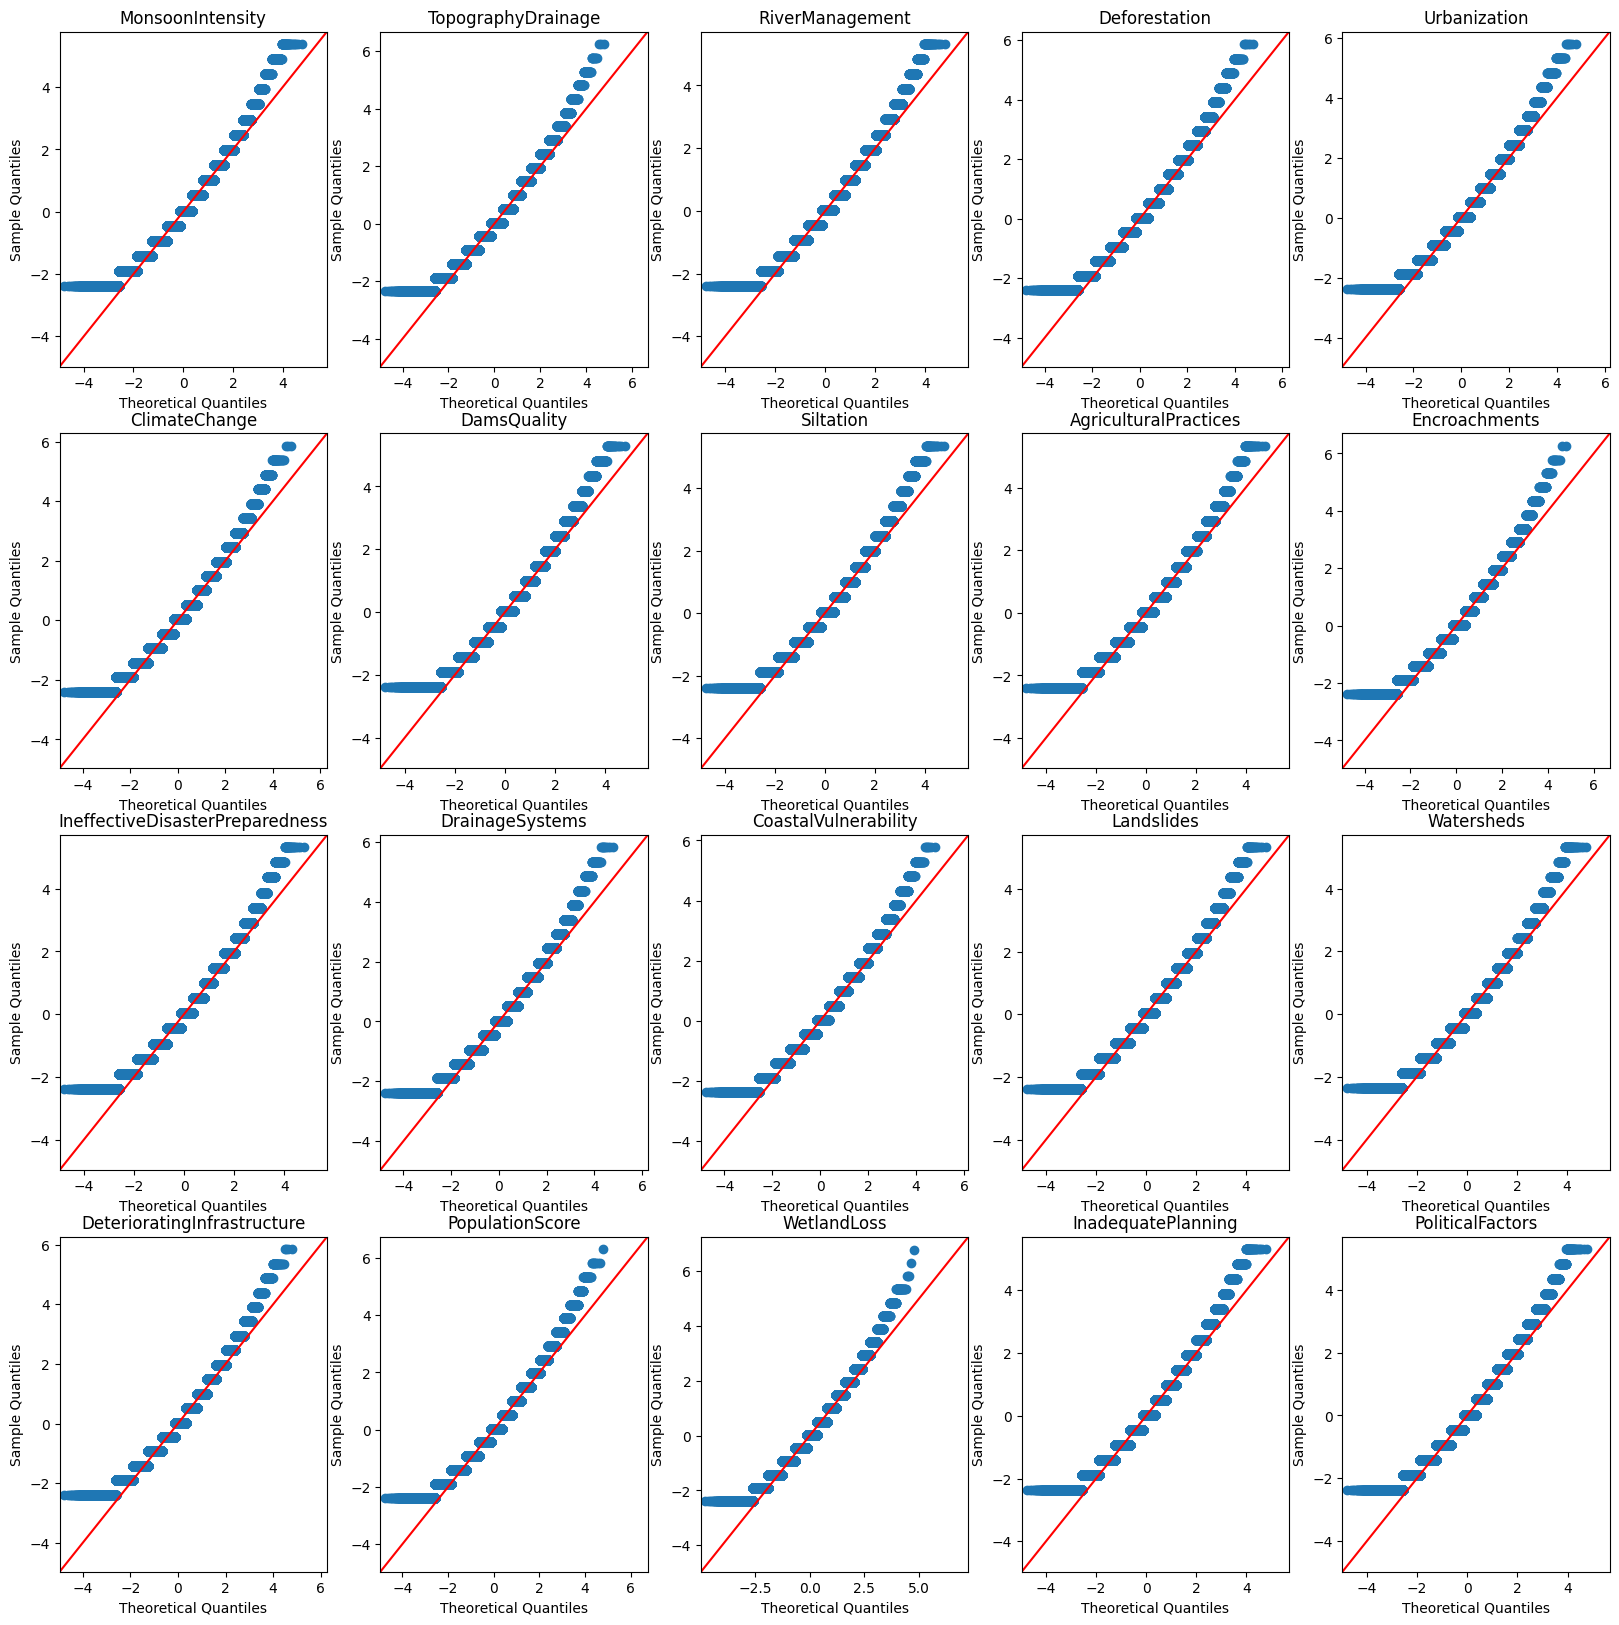

In [86]:
# Check distribution
scaler = StandardScaler()

fig, axs = plt.subplots(4, 5, figsize=(20, 20))

for i, column in enumerate(train_columns):
    ax = axs[i // 5, i % 5]
    data_points = train_data[column].sort_values().values
    data_points = np.reshape(data_points, (-1, 1))
    data_points = scaler.fit_transform(data_points)
    sm.qqplot(data_points, line ='45', ax=ax)
    ax.set_title(column)
plt.show()

✨ It seems that almost all features are close to the normal distribution. For this reason, I would prefer standardization in the pre-processing of the data.

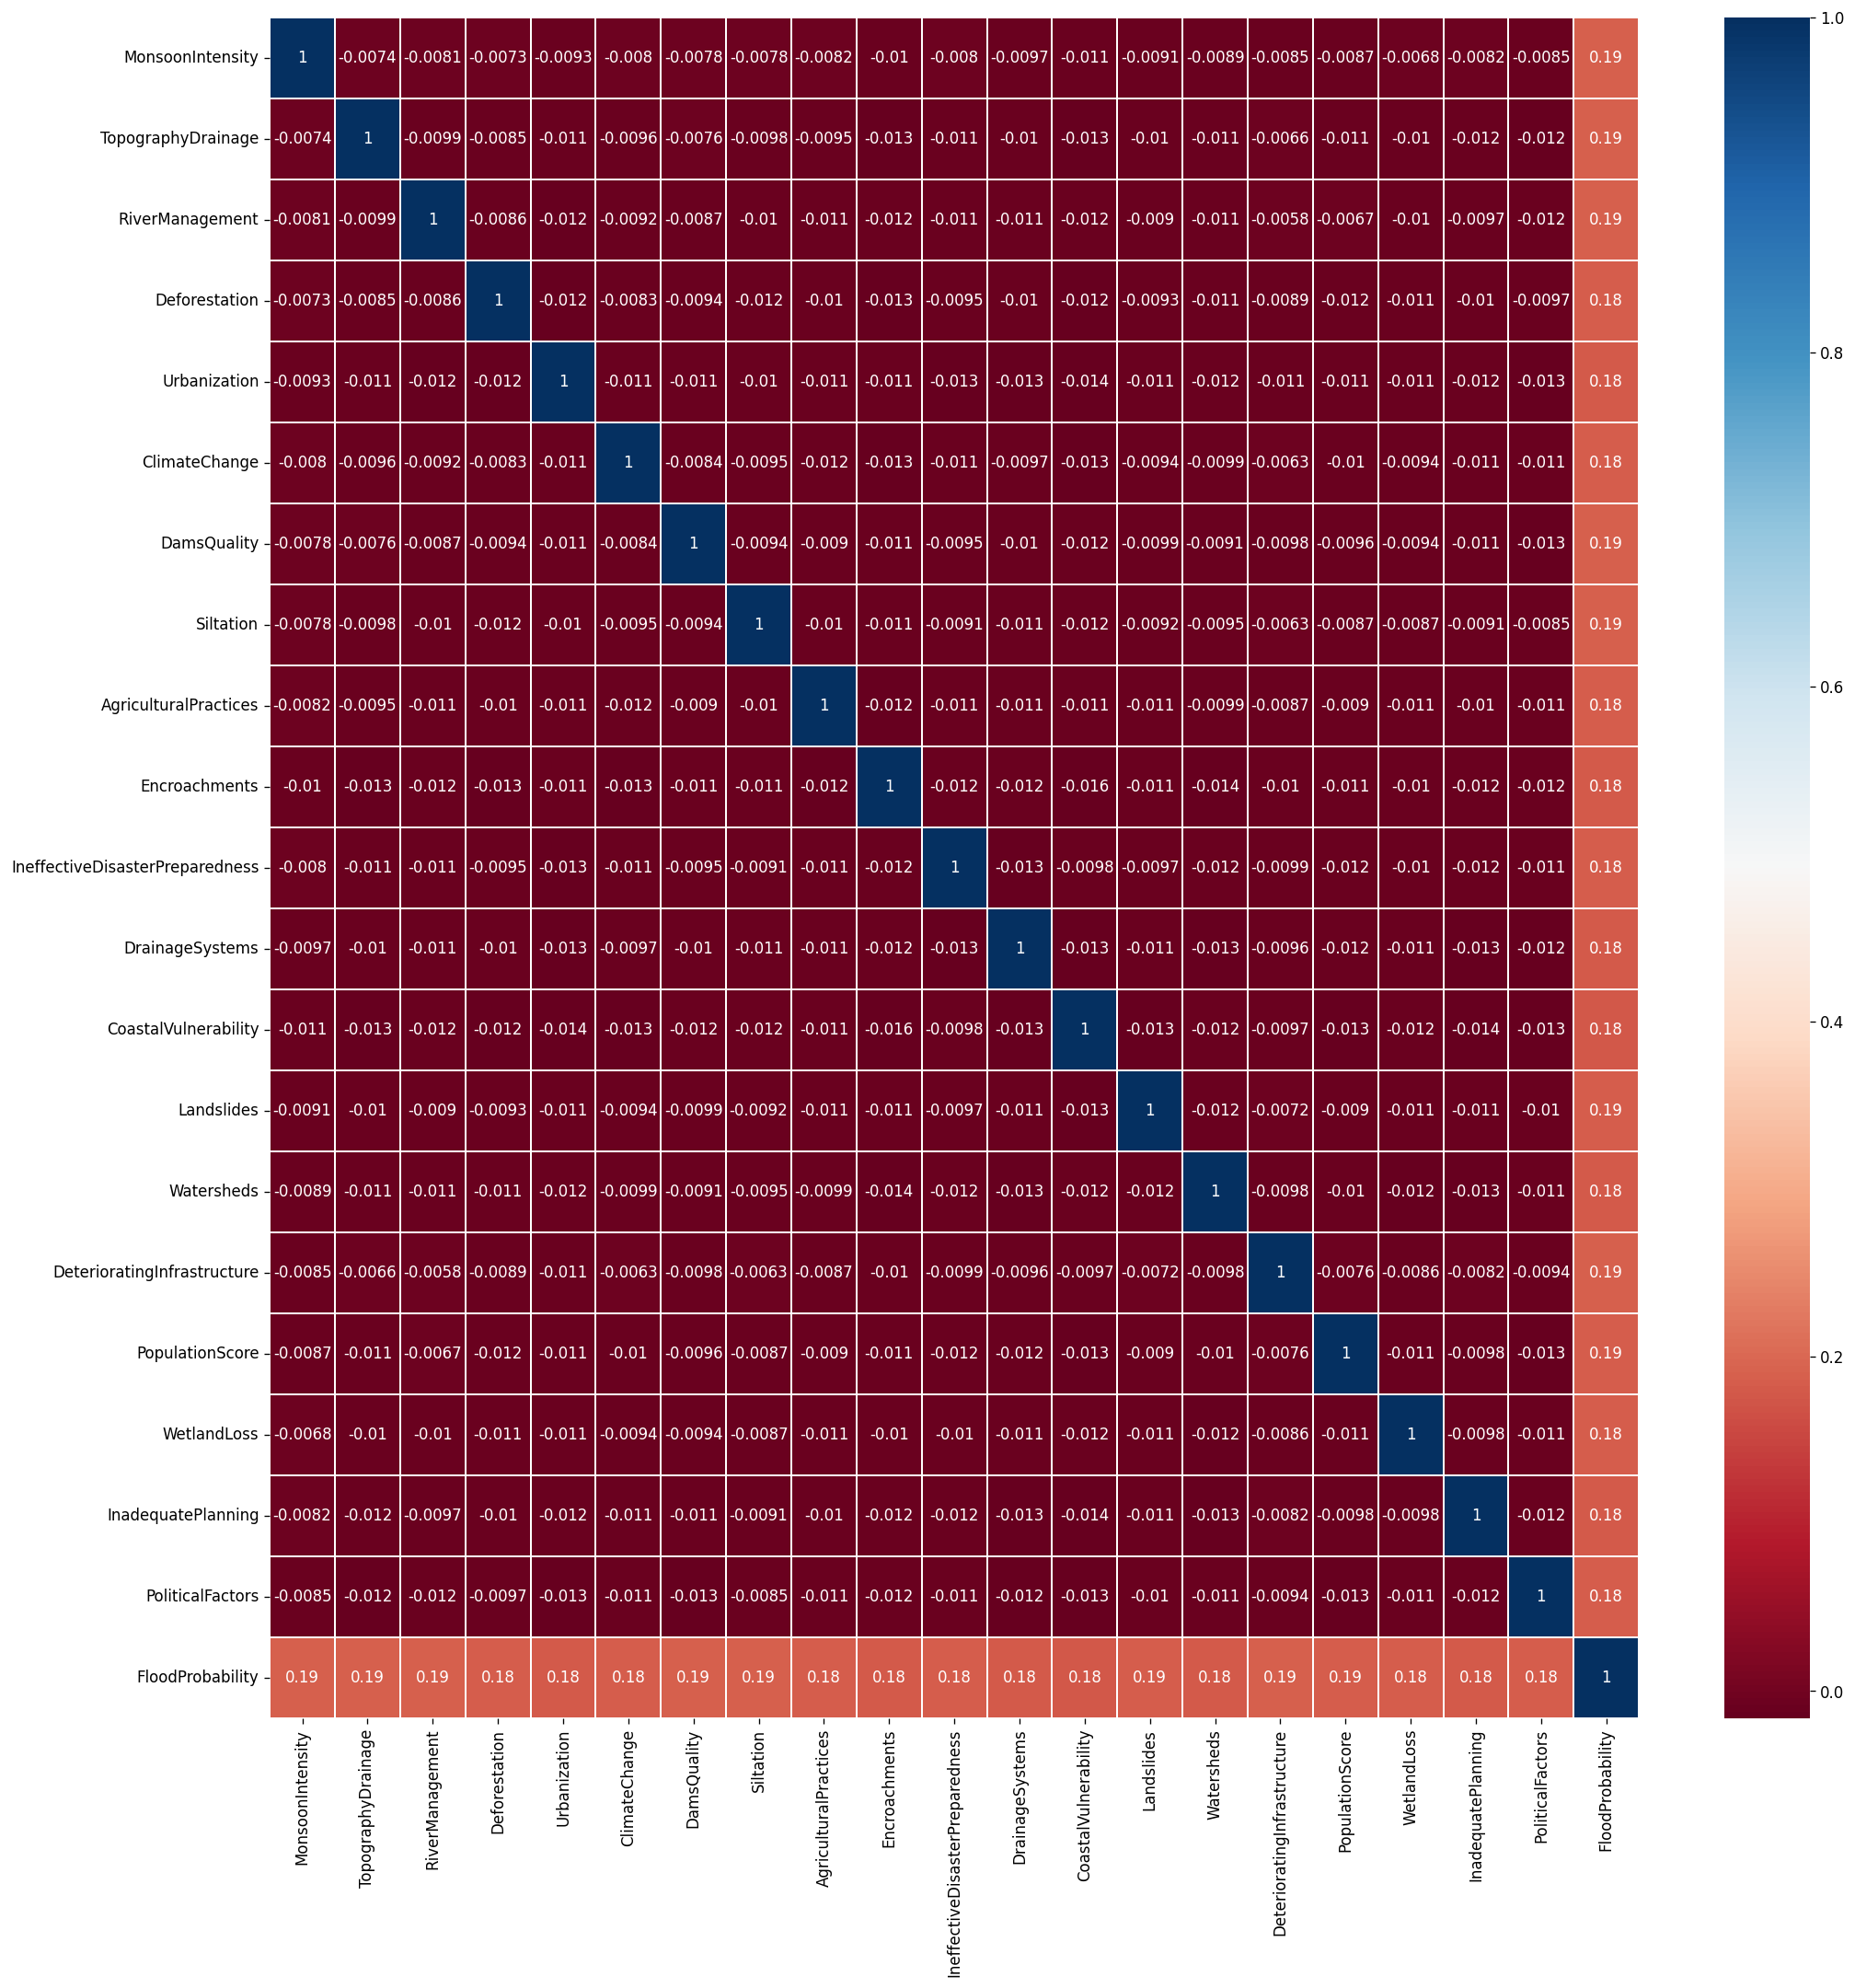

In [87]:
fig, ax = plt.subplots(figsize=(20, 20), dpi=120)
corr = train_data.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
      linewidth=0.2, annot=True, cmap='RdBu', ax=ax);

✨ It seems that each feature has similar relevance to the probability of flooding. However, in the next step, I will test how much impact each feature will have on the results to determine which features are more important.

# Model Training with small dataset

In this step, I will confirm that:
1. Simply test on a small data set (10% dataset).

2. Drop each feature in order to determine how much impact on FloodProbability.


3. Apply Voting, Bagging, and Stacking algorithms on small dataset.

4. Apply GridSearchCV for hyperparameter searching to find the best model if it exists.

## Create X and y with 10 percent data

In [4]:
index = int(len(train_data) * 0.1)
X = train_data.drop("FloodProbability", axis=1).iloc[:index, :]
y = train_data["FloodProbability"][:index]

## Check the impact of features on results.

In [91]:
features = ['pass']
for col in train_data.columns[:-1]:
    if col != 'FloodProbability':
        features.append(col)

features

['pass',
 'MonsoonIntensity',
 'TopographyDrainage',
 'RiverManagement',
 'Deforestation',
 'Urbanization',
 'ClimateChange',
 'DamsQuality',
 'Siltation',
 'AgriculturalPractices',
 'Encroachments',
 'IneffectiveDisasterPreparedness',
 'DrainageSystems',
 'CoastalVulnerability',
 'Landslides',
 'Watersheds',
 'DeterioratingInfrastructure',
 'PopulationScore',
 'WetlandLoss',
 'InadequatePlanning',
 'PoliticalFactors']

In [92]:
# random seed
seed = 42
np.random.seed(seed)

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# build pipeline
def train(X, y):
    model = make_pipeline(StandardScaler(), LinearRegression())
    model.fit(X, y)
    return model

scores_10_percent_data = {}
for feature in features:
    if feature == 'pass':
        model = train(X_train, y_train)
        name = feature
        y_pred = model.predict(X_test)
    else:
        model = train(X_train.drop(feature, axis=1), y_train)
        name = feature + '_dropped'
        y_pred = model.predict(X_test.drop(feature, axis=1))
    r2 = np.round(r2_score(y_test, y_pred), 5)
    scores_10_percent_data[name] = r2

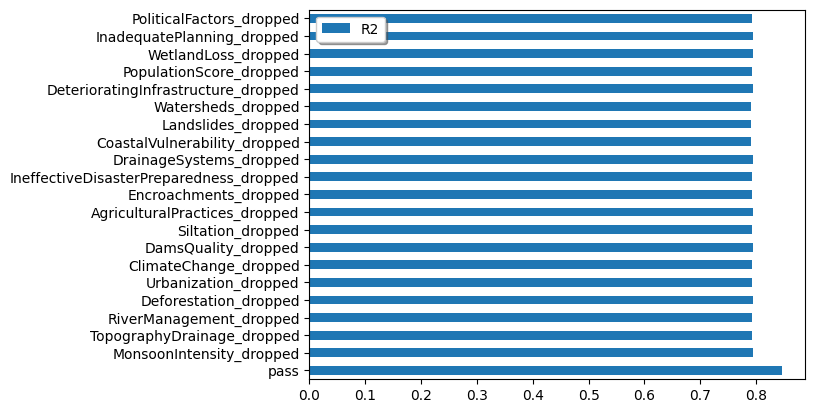

In [93]:
pd.DataFrame(scores_10_percent_data, index=['R2']).T.plot.barh()
plt.legend(loc='upper left', fancybox=True, shadow=True, frameon=True);

## Train models on small dataset

In [94]:
# models for searching
models_for_search = {
    'BaggingRegressor_ridge': BaggingRegressor(estimator=Ridge(), n_estimators=50),
    'BaggingRegressor_lasso': BaggingRegressor(estimator=Lasso(alpha=1e-3), n_estimators=50),
    'VotingRegressor': VotingRegressor(
        estimators=[('rf', LinearRegression()),
              ('lr_r', Ridge()),
              ('lr_L', Lasso(alpha=1e-3))]),
    'StackingRegressor': StackingRegressor(
        estimators=[('rf', LinearRegression()),
              ('lr_r', Ridge()),
              ('lr_L', Lasso(alpha=1e-3))],
        final_estimator=LinearRegression())}

def fit_and_score(X, y, rescaler, models_for_search, seed=42):
    """
    Use train set to fit model and score the test set

    Args:
        X_scaled: All data with rescaling
        y: All labels
        models are packaged in dictionary

    Returns:
        Best model and best score
    """
    np.random.seed(seed)
    train_scores_dict = {}
    better_score = -1
    better_model_info = (None, None) # (name,  model)

    for name, train_model in tqdm(models_for_search.items()):
        model = make_pipeline(rescaler, train_model)
        R2_score = np.mean(cross_val_score(model, X, y, scoring='r2', cv=5))
        train_scores_dict[name] = R2_score

        if R2_score > better_score:
            better_score = R2_score
            better_model_info = (name, model)
        else:
            pass

    return better_score, better_model_info, train_scores_dict

In [95]:
# training
score, model_info, training_info = fit_and_score(X=X, y=y, rescaler=StandardScaler(), models_for_search=models_for_search)

# update training results
best_score = score
best_model_name = model_info[0]
best_model = model_info[1]

print()
print('Best Model:', best_model_name)
print(best_model)
print("Score:", best_score)

100%|██████████| 4/4 [00:44<00:00, 11.24s/it]


Best Model: BaggingRegressor_ridge
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('baggingregressor',
                 BaggingRegressor(estimator=Ridge(), n_estimators=50))])
Score: 0.8453446957634811


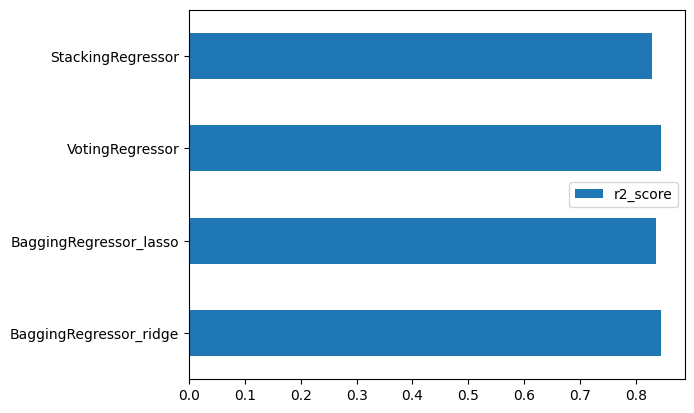

In [96]:
training_results = pd.DataFrame(training_info, index=['r2_score']).T
training_results.plot.barh();

## GridSearchCV

In [97]:
n_estimators = [30, 50, 80]

parameters = {'n_estimators': n_estimators}
clf = GridSearchCV(BaggingRegressor(estimator=Ridge(), n_estimators=20), parameters, cv=5, scoring='r2', verbose=2)
X_scaled = StandardScaler().fit_transform(X)
clf.fit(X_scaled, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ....................................n_estimators=30; total time=   1.4s
[CV] END ....................................n_estimators=30; total time=   1.5s
[CV] END ....................................n_estimators=30; total time=   1.5s
[CV] END ....................................n_estimators=30; total time=   1.5s
[CV] END ....................................n_estimators=30; total time=   1.5s
[CV] END ....................................n_estimators=50; total time=   4.2s
[CV] END ....................................n_estimators=50; total time=   3.3s
[CV] END ....................................n_estimators=50; total time=   2.5s
[CV] END ....................................n_estimators=50; total time=   2.5s
[CV] END ....................................n_estimators=50; total time=   2.4s
[CV] END ....................................n_estimators=80; total time=   6.1s
[CV] END ....................................n_es

GridSearchCV(cv=5,
             estimator=BaggingRegressor(estimator=Ridge(), n_estimators=20),
             param_grid={'n_estimators': [30, 50, 80]}, scoring='r2',
             verbose=2)

In [98]:
clf.best_params_

{'n_estimators': 80}

In [110]:
print(f"Scores using GridSearchCV: {clf.best_score_}")

if clf.best_score_ > best_score:
    best_clf = clf.best_estimator_
else:
    best_clf = best_model

Scores using GridSearchCV: 0.845348489497711


# Model Training with full dataset

In [111]:
X = train_data.drop("FloodProbability", axis=1)
y = train_data["FloodProbability"]

In [112]:
X.head().T

id,0,1,2,3,4
MonsoonIntensity,5,6,6,3,5
TopographyDrainage,8,7,5,4,3
RiverManagement,5,4,6,6,2
Deforestation,8,4,7,5,6
Urbanization,6,8,3,4,4
ClimateChange,4,8,7,8,4
DamsQuality,4,3,1,4,3
Siltation,3,5,5,7,3
AgriculturalPractices,3,4,4,6,3
Encroachments,4,6,5,8,3


In [113]:
y.head()

id
0    0.445
1    0.450
2    0.530
3    0.535
4    0.415
Name: FloodProbability, dtype: float64

In [114]:
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.02, random_state=seed)

In [115]:
best_clf.fit(X_train, y_train)
y_preds = best_clf.predict(X_test)

In [116]:
r2_score(y_test, y_preds)

0.8434990393591824

# Submission

In [106]:
# Create test data
X_test = test_data

# Rescale data
X_test = StandardScaler().fit_transform(X_test)

# Model prediction
y_preds = best_clf.predict(X_test)

In [107]:
# Create submission data
target_col = "FloodProbability"
sub_data[target_col] = y_preds

In [108]:
sub_data.head()

,id,FloodProbability
0,1117957,0.573393
1,1117958,0.455164
2,1117959,0.454726
3,1117960,0.466095
4,1117961,0.466058


In [109]:
# Save the submission dataframe to a CSV file
sub_data.to_csv(os.path.join(data_dir, 'submission.csv'), index=False)